In [1]:
import time
import numpy as np
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import learning_curve, GridSearchCV

from utils import read_data, plot_contour

2024-04-22 17:01:22.172003: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 17:01:22.439089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 17:01:23.057654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_filename = f"data_oneleak_train(stratify)_without_outliers"
test_filename = f"data_oneleak_test(stratify)_without_outliers"

In [3]:
df_train = read_data(path=f"./data/{train_filename}.csv")
df_test = read_data(path=f"./data/{test_filename}.csv")

points_fill = np.array(np.loadtxt("./data/fill.csv"))
points_contour = np.array(np.loadtxt("./data/contour.csv"))

In [4]:
x_train, x_test, y_train, y_test = df_train[["y1","y2"]], df_test[["y1","y2"]], np.array(tf.argmax(df_train.iloc[:,:10].values, axis=1) + 1), np.array(tf.argmax(df_test.iloc[:,:10].values, axis=1) + 1),

2024-04-22 17:01:25.103113: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("classification_network", MLPClassifier(solver="lbfgs", alpha=1e-1, hidden_layer_sizes=(5,), random_state=42))]
)

In [8]:
# Define the parameters for grid search
param_grid = {
    'classification_network__alpha': [1e-2, 1e-1, 1, 10],  # Regularization parameter
    'classification_network__hidden_layer_sizes': [(5,), (10,), (5, 2), (10, 5)],  # Hidden layer sizes
    'classification_network__activation':['relu','softmax']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

/home/hemant/Desktop custom/University/Courses/Semester 4/Studienarbeit/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/hemant/Desktop custom/University/Courses/Semester 4/Studienarbeit/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/hemant/Desktop custom/University/Courses/Semes

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classification_network',
                                        MLPClassifier(alpha=0.1,
                                                      hidden_layer_sizes=(5,),
                                                      random_state=42,
                                                      solver='lbfgs'))]),
             n_jobs=-1,
             param_grid={'classification_network__activation': ['relu',
                                                                'softmax'],
                         'classification_network__alpha': [0.01, 0.1, 1, 10],
                         'classification_network__hidden_layer_sizes': [(5,),
                                                                        (10,),
                                                                        (5, 2),
                                                                        (10,
                                                                         5)]})

In [9]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'classification_network__activation': 'relu', 'classification_network__alpha': 0.1, 'classification_network__hidden_layer_sizes': (5,)}
Best Score: 0.9649068322981366


In [23]:
start = time.time()

# Use the best parameters found by grid search
best_mlp_params = grid_search.best_params_

# Extract the relevant parameters for MLPClassifier
best_mlp_clf = MLPClassifier(**{key.split('__')[1]: value for key, value in best_mlp_params.items() if 'classification_network' in key}, solver="lbfgs", random_state=42)

# Define the pipeline with the best parameters
best_clf = Pipeline(steps=[("scaler", StandardScaler()), ("classification_network", best_mlp_clf)])

# Fit the pipeline with the best parameters to the training data
best_clf.fit(x_train, y_train)

# Evaluate the performance of the best classifier
accuracy = best_clf.score(x_test, y_test)

end = time.time()

print("Accuracy of the best classifier on test set: {:.2f}".format(accuracy))

Accuracy of the best classifier on test set: 0.92


/home/hemant/Desktop custom/University/Courses/Semester 4/Studienarbeit/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [24]:
print(f"Time required to fit the model: {end-start} seconds.")

Time required to fit the model: 0.07701563835144043 seconds.


In [25]:
def accuracy(y_pred,y_true):
    return np.sum(y_pred==y_true)/len(y_true)

In [26]:
y_pred = best_clf.predict(x_test)

In [27]:
train_accuracy = accuracy(best_clf.predict(x_train),y_train)
test_accuracy = accuracy(y_pred=y_pred,y_true=y_test)

In [28]:
print(f"Classification network training data accuracy: {train_accuracy*100}")
print(f"Classification network unseen data accuracy: {test_accuracy*100}")

Classification network training data accuracy: 98.24561403508771
Classification network unseen data accuracy: 92.15686274509804


#### Training data visualisation

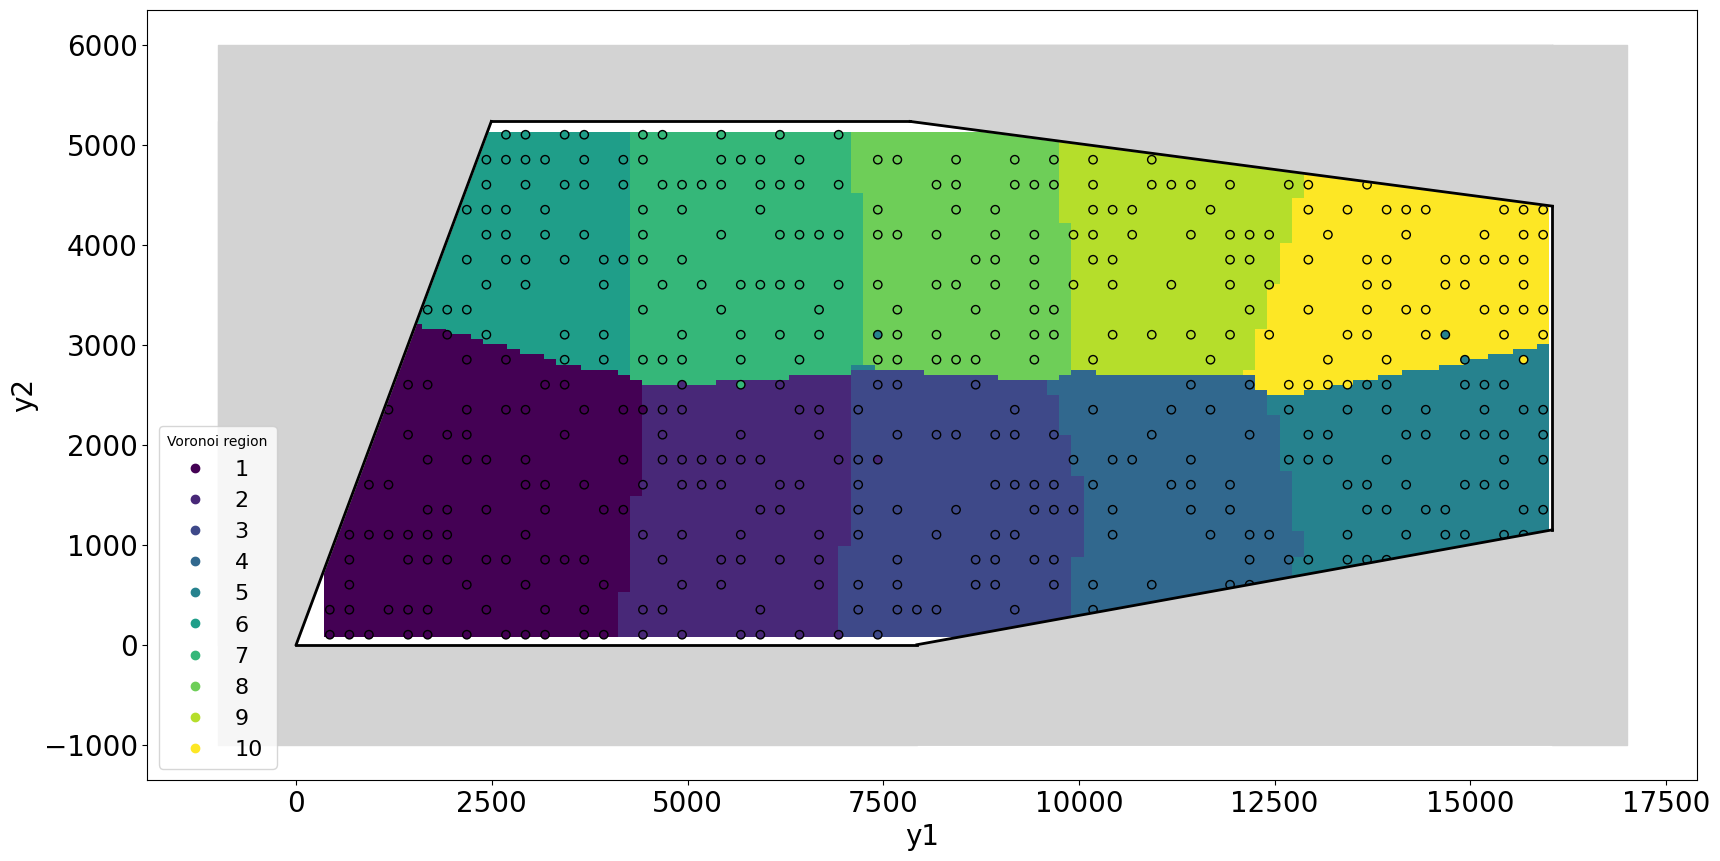

In [29]:
fig, axs = plt.subplots(nrows=1, figsize=(20, 10))
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)

plot_contour(points_contour,points_fill)

disp = DecisionBoundaryDisplay.from_estimator(
    best_clf,
    x_train,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="y1",
    ylabel="y2",
    shading="auto",
    ax=axs
)
scatter = disp.ax_.scatter(x_train.iloc[:,0], x_train.iloc[:,1], c=y_train, edgecolors="k")

disp.ax_.legend(
    scatter.legend_elements()[0],
    list(set(y_train)),
    loc="lower left",
    title="Voronoi region",
)
# _ = disp.ax_.set_title(
#     f"MLP Classification network for Training data\nTraining accuracy: {round(train_accuracy*100,2)}\n{train_filename}.csv"
# )

plt.show()


In [34]:
fig.savefig(f"./plots/Final/Stratify/With outliers/Classification_network_training(stratify).png")

### Test data visualisation

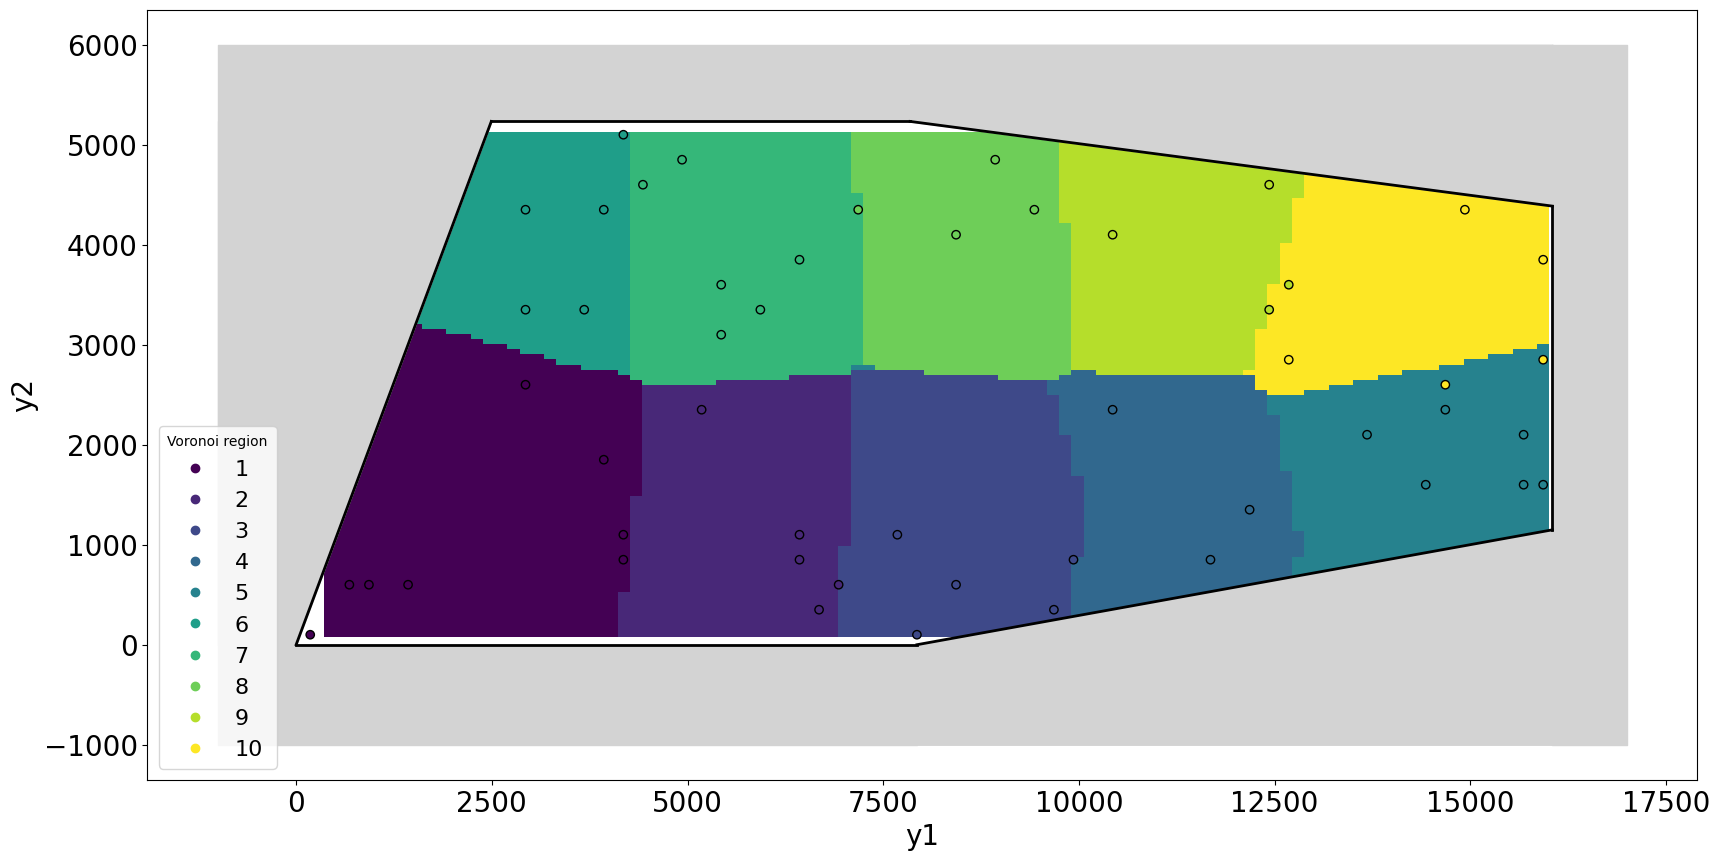

In [30]:
fig, axs = plt.subplots(nrows=1, figsize=(20, 10))
plot_contour(points_contour,points_fill)

disp = DecisionBoundaryDisplay.from_estimator(
    best_clf,
    x_train,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="y1",
    ylabel="y2",
    shading="auto",
    ax=axs
)
scatter = disp.ax_.scatter(x_test.iloc[:,0], x_test.iloc[:,1], c=y_test, edgecolors="k")

disp.ax_.legend(
    scatter.legend_elements()[0],
    list(set(y_train)),
    loc="lower left",
    title="Voronoi region",
)
# _ = disp.ax_.set_title(
#     f"MLP Classification network for Testing data\nTesting accuracy: {round(test_accuracy*100,2)}\n{test_filename}.csv"
# )

plt.show()


In [36]:
fig.savefig(f"./plots/Final/Stratify/With outliers/Classification_network_testing(stratify).png")

/home/hemant/Desktop custom/University/Courses/Semester 4/Studienarbeit/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/hemant/Desktop custom/University/Courses/Semester 4/Studienarbeit/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/hemant/Desktop custom/University/Courses/Semes

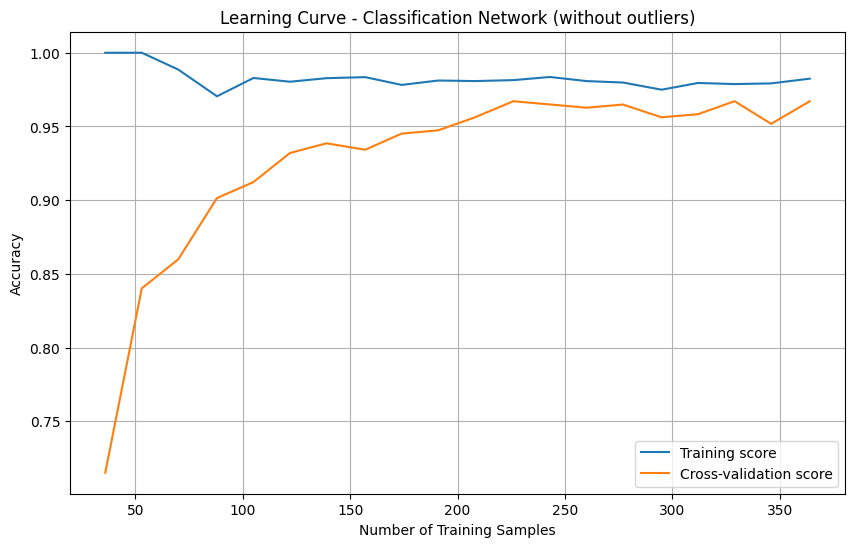

In [55]:
train_sizes, train_scores, valid_scores = learning_curve(best_clf, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 20), cv=5)

fig = plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curve - Classification Network (without outliers)')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
fig.savefig("./plots/Final/Stratify/Without outliers/Learning curve - Classification network.png")